# Class Imbalance Simulation
## Objective

This notebook demonstrates how to systematically simulate class imbalance in classification problems, with:

- Explicit control over imbalance ratios

- Business-realistic rare-event generation

- Separation between signal strength and prevalence

- Ground truth probabilities for evaluation

The resulting datasets are used downstream for:

- Imbalanced learning techniques

- Metric benchmarking

- Threshold tuning

- Business-cost analysis

## Why Class Imbalance Must Be Simulated Explicitly

In real business problems (fraud, churn, default, failures):

- The minority class is usually the most valuable

- Accuracy becomes misleading

- Naive models appear “good” while failing operationally

Simulating imbalance correctly allows us to:

- Test detection under scarcity

- Separate model skill from class frequency

- Benchmark mitigation strategies fairly

# Imports and Configuration

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc
)

RANDOM_STATE = 2010
np.random.seed(RANDOM_STATE)


# Step 1 – Generate Base Features

We reuse the same feature space across imbalance scenarios to isolate the effect of prevalence.

In [2]:
N_SAMPLES = 8000

age = np.random.randint(18, 70, size=N_SAMPLES)

income = np.random.normal(
    loc=60000,
    scale=15000,
    size=N_SAMPLES
).clip(20000, 150000)

tenure = np.random.exponential(scale=5, size=N_SAMPLES).clip(0, 30)

region = np.random.choice(
    ["North", "South", "East", "West"],
    size=N_SAMPLES,
    p=[0.25, 0.25, 0.30, 0.20]
)

product_type = np.random.choice(
    ["Basic", "Standard", "Premium"],
    size=N_SAMPLES,
    p=[0.45, 0.35, 0.20]
)

# Step 2 – Latent Risk Score (True Signal)
This score represents true risk propensity (e.g., fraud likelihood).


In [3]:
score = (
    -7.5
    + 0.035 * age
    + 0.0005 * income
    - 0.000000003 * income**2
    + 1.6 * np.log1p(tenure)
)

## Categorical Effects

In [6]:
region_effect = pd.Series(region).map({
    "North": 0.5,
    "East": 0.3,
    "South": 0.0,
    "West": -0.4
}).values

product_effect = pd.Series(product_type).map({
    "Basic": -0.6,
    "Standard": 0.2,
    "Premium": 1.4
}).values

score += region_effect + product_effect

# Step 3 – Add Noise (Uncertainty)

In [7]:
noise = np.random.normal(
    loc=0,
    scale=0.9,
    size=N_SAMPLES
)

score += noise


# Step 4 – Convert Score to Probability

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

true_probability = sigmoid(score)


# Step 5 – Create Multiple Imbalance Scenarios

We now control class prevalence without changing signal quality.

## Helper Function

In [5]:
def generate_target(probabilities, prevalence):
    threshold = np.quantile(probabilities, 1 - prevalence)
    return (probabilities >= threshold).astype(int)


__Scenarios__

In [6]:
imbalance_scenarios = {
    "balanced_50_50": 0.50,
    "moderate_20_80": 0.20,
    "rare_10_90": 0.10,
    "very_rare_05_95": 0.05,
    "extreme_01_99": 0.01
}

# Step 6 – Assemble Dataset per Scenario

In [11]:
datasets = {}

for name, prevalence in imbalance_scenarios.items():
    y = generate_target(true_probability, prevalence)

    df_scenario = pd.DataFrame({
        "age": age,
        "income": income,
        "tenure": tenure,
        "region": region,
        "product_type": product_type,
        "target": y,
        "true_probability": true_probability
    })

    datasets[name] = df_scenario

    print(name, df_scenario["target"].mean())


balanced_50_50 0.5
moderate_20_80 0.2
rare_10_90 0.1
very_rare_05_95 0.05
extreme_01_99 0.01


# Step 7 – Visualize Class Distributions

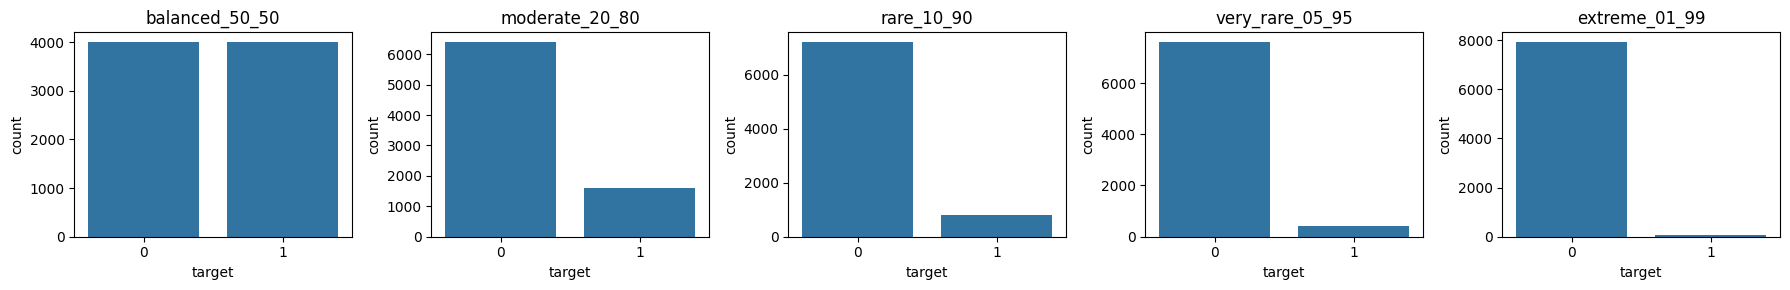

In [13]:
fig, axes = plt.subplots(1, 5, figsize=(18, 3))

for ax, (name, df_s) in zip(axes, datasets.items()):
    sns.countplot(x="target", data=df_s, ax=ax)
    ax.set_title(name)

plt.tight_layout()
plt.show()


# Step 8 – Baseline Modeling Without Mitigation

We intentionally train naive models to expose failure modes.

## Preprocessing Pipeline

In [14]:
numeric_features = ["age", "income", "tenure"]
categorical_features = ["region", "product_type"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(drop="first"), categorical_features)
    ]
)


## Evaluation Function

In [15]:
def evaluate_model(df, label):
    X = df.drop(columns=["target", "true_probability"])
    y = df["target"]

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.25,
        stratify=y,
        random_state=RANDOM_STATE
    )

    model = Pipeline(
        steps=[
            ("preprocessing", preprocessor),
            ("model", LogisticRegression(max_iter=1000))
        ]
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n{label}")
    print(classification_report(y_test, y_pred, digits=3))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))


## Run Evaluation

In [16]:
for name, df_s in datasets.items():
    evaluate_model(df_s, name)



balanced_50_50
              precision    recall  f1-score   support

           0      0.863     0.838     0.850      1000
           1      0.843     0.867     0.855      1000

    accuracy                          0.853      2000
   macro avg      0.853     0.853     0.852      2000
weighted avg      0.853     0.853     0.852      2000

ROC-AUC: 0.925722

moderate_20_80
              precision    recall  f1-score   support

           0      0.902     0.952     0.926      1600
           1      0.753     0.588     0.660       400

    accuracy                          0.879      2000
   macro avg      0.828     0.770     0.793      2000
weighted avg      0.872     0.879     0.873      2000

ROC-AUC: 0.936434375


C:\Users\pantu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



rare_10_90
              precision    recall  f1-score   support

           0      0.940     0.978     0.959      1800
           1      0.693     0.440     0.538       200

    accuracy                          0.924      2000
   macro avg      0.817     0.709     0.749      2000
weighted avg      0.915     0.924     0.917      2000

ROC-AUC: 0.9426888888888888


C:\Users\pantu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



very_rare_05_95
              precision    recall  f1-score   support

           0      0.969     0.989     0.979      1900
           1      0.667     0.400     0.500       100

    accuracy                          0.960      2000
   macro avg      0.818     0.695     0.740      2000
weighted avg      0.954     0.960     0.955      2000

ROC-AUC: 0.9564052631578949

extreme_01_99
              precision    recall  f1-score   support

           0      0.991     0.999     0.995      1980
           1      0.750     0.150     0.250        20

    accuracy                          0.991      2000
   macro avg      0.871     0.575     0.623      2000
weighted avg      0.989     0.991     0.988      2000

ROC-AUC: 0.9793686868686868


# Step 9 – Precision–Recall Degradation

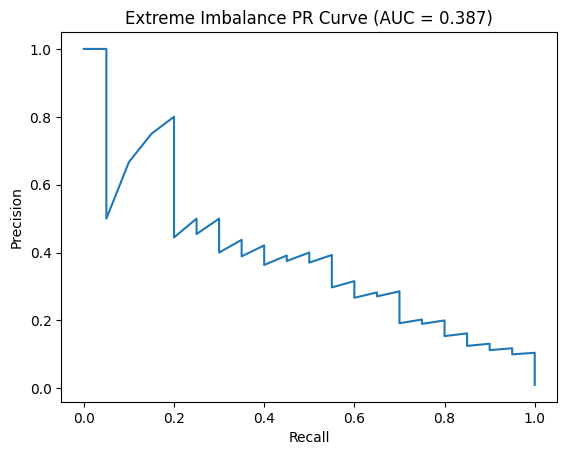

In [17]:
df_extreme = datasets["extreme_01_99"]

X = df_extreme.drop(columns=["target", "true_probability"])
y = df_extreme["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)

model = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("model", LogisticRegression(max_iter=1000))
    ]
)

model.fit(X_train, y_train)
y_proba = model.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Extreme Imbalance PR Curve (AUC = {pr_auc:.3f})")
plt.show()


# Step 10 – Key Observations

- Accuracy remains deceptively high as imbalance increases

- Recall for minority class collapses

- ROC-AUC may remain stable while PR-AUC deteriorates

- Models trained without mitigation are operationally useless under extreme imbalance

# Step 11 – Business Interpretation

Examples:
- 
- Fraud detection: 1% fraud rate

- Equipment failure: <0.5% events

- Medical screening: rare diseases

Failing to address imbalance leads to:

- Missed critical events

- False confidence in model quality

- Poor ROI and reputational risk

## Summary

This notebook demonstrated:

- How to generate imbalance independently of signal

- How prevalence alone breaks naive models

- Why evaluation metrics must change

- Why imbalance must be addressed by design

This notebook sets the foundation for:

- Resampling techniques

- Cost-sensitive learning

- Threshold tuning

- Business-aligned evaluation